In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay)

import time

seed = 23

In [ ]:
train_full = pd.read_csv("/content/fraudTest.csv")
print("Original train shape:", train_full.shape)
print(train_full['is_fraud'].value_counts(normalize=True))

Original train shape: (555719, 23)
is_fraud
0    0.99614
1    0.00386
Name: proportion, dtype: float64


In [ ]:
# Stratified sample (200k rows)
sample_size = 200_000
frac = sample_size / len(train_full)

_, sample_df = train_test_split(train_full, train_size=sample_size, stratify=train_full["is_fraud"], random_state=seed)
print("Sampled dataset shape:", sample_df.shape)
print(sample_df['is_fraud'].value_counts())

Sampled dataset shape: (355719, 23)
is_fraud
0    354346
1      1373
Name: count, dtype: int64


In [ ]:
# Feature Engineering
# Convert timestamp to hour
sample_df["trans_date_trans_time"] = pd.to_datetime(sample_df["trans_date_trans_time"])
sample_df["hour"] = sample_df["trans_date_trans_time"].dt.hour

# Abnormal hour encoding: 1 if before 5AM or after 9PM
sample_df["hourEnc"] = sample_df["hour"].apply(lambda h: 1 if (h < 5 or h > 21) else 0)

# Distance (Euclidean approx)
sample_df["distance"] = np.sqrt(
    (sample_df["lat"] - sample_df["merch_lat"])**2 +
    (sample_df["long"] - sample_df["merch_long"])**2)

In [ ]:
# Drop Columns
drop_cols = [
    "Unnamed: 0", "cc_num", "first", "last", "street",
    "city", "state", "zip", "trans_num", "dob", "trans_date_trans_time",
    "merchant", "job", "lat", "long", "merch_lat", "merch_long"
]
cols_to_drop = [c for c in drop_cols if c in sample_df.columns]
sample_df = sample_df.drop(columns=cols_to_drop)

In [ ]:
# Dummy Variables
cat_cols = ["category", "gender"]
sample_df = pd.get_dummies(sample_df,
                           columns=[c for c in cat_cols if c in sample_df.columns], drop_first=True)

In [ ]:
# Seperate labels
y = sample_df["is_fraud"]
X = sample_df.drop(columns=["is_fraud"])

In [ ]:
# Numeric columns for scaling
numeric_cols = ["amt", "city_pop", "unix_time", "distance", "hour"]
numeric_cols = [c for c in numeric_cols if c in X.columns]

In [ ]:
# Split test/train sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=seed)
print("Train/test shapes:", X_train.shape, X_test.shape)
print("Test fraud rate:", y_test.mean())

Train/test shapes: (249003, 20) (106716, 20)
Test fraud rate: 0.0038607144195809437


In [ ]:
# Standardize numeric columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [ ]:
# Apply smote to train data
smote = SMOTE(random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE training shape:", X_train_smote.shape)
print("Class balance (train SMOTE):", pd.Series(y_train_smote).value_counts())

After SMOTE training shape: (496084, 20)
Class balance (train SMOTE): is_fraud
0    248042
1    248042
Name: count, dtype: int64


In [ ]:
# Evualuation function
def evaluate_model(model, X_test, y_test):
    """
    Evaluates a classification model using standard metrics.
    Prints metrics and returns them.
    """

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall    = recall_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred)
    auc       = roc_auc_score(y_test, y_prob)

    # Print results in your preferred style
    print("Accuracy :", accuracy)
    print("Precision:", precision)
    print("Recall   :", recall)
    print("F1 Score :", f1)
    print("ROC AUC  :", auc)

    # Return for tables or comparison
    return {"accuracy": accuracy,"precision": precision,"recall": recall,"f1": f1,"auc": auc}


In [ ]:
# Train Logistic Regression
print("Training Logistic Regression")
lr = LogisticRegression(max_iter=2000, random_state=seed)

# Quick RandomizedSearch for C
lr_param_dist = {"C": [0.01, 0.1, 1, 5, 10]}
lr_search = RandomizedSearchCV(lr, lr_param_dist, scoring="f1", cv=3, n_iter=5, random_state=seed, n_jobs=-1)
start = time.time()
lr_search.fit(X_train_smote, y_train_smote)
end = time.time()
print(f"LR tuning done in {(end-start):.1f}s")
best_lr = lr_search.best_estimator_
print("Best LR params:", lr_search.best_params_)

lr_metrics = evaluate_model(best_lr, X_test, y_test)

Training Logistic Regression
LR tuning done in 41.0s
Best LR params: {'C': 10}
Accuracy : 0.8752764346489749
Precision: 0.024830533451223106
Recall   : 0.8179611650485437
F1 Score : 0.04819794050343249
ROC AUC  : 0.9345579201688653


In [ ]:
# Train Random Forest
print("Training Random Forest")
rf = RandomForestClassifier(random_state=seed, n_jobs=-1)

rf_param_dist = {
    "n_estimators": [100],
    "max_depth": [6],
    "min_samples_split": [2],
    "min_samples_leaf": [1]}

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=1,
    scoring="roc_auc",
    cv=2,
    random_state=seed,
    n_jobs=-1)
start = time.time()
rf_random.fit(X_train_smote, y_train_smote)
end = time.time()
print(f"RF tuning done in {(end-start):.1f}s")
print("Best parameters:", rf_random.best_params_)
print("Best AUC:", rf_random.best_score_)
best_rf = rf_random.best_estimator_
rf_metrics = evaluate_model(best_rf, X_test, y_test)
print("Random Forest Metrics:", rf_metrics)

Training Random Forest
RF tuning done in 127.4s
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 6}
Best AUC: 0.990478704546411
Accuracy : 0.9546459762359909
Precision: 0.07009708737864077
Recall   : 0.8762135922330098
F1 Score : 0.129809421071557
ROC AUC  : 0.9647015721170427
Random Forest Metrics: {'accuracy': 0.9546459762359909, 'precision': 0.07009708737864077, 'recall': 0.8762135922330098, 'f1': 0.129809421071557, 'auc': np.float64(0.9647015721170427)}


In [ ]:
# Results table
results = pd.DataFrame([
    {"model":"Logistic Regression","accuracy":lr_metrics["accuracy"], "precision":lr_metrics["precision"],
     "recall":lr_metrics["recall"], "f1":lr_metrics["f1"], "auc":lr_metrics["auc"]},
    {"model":"Random Forest","accuracy":rf_metrics["accuracy"], "precision":rf_metrics["precision"],
     "recall":rf_metrics["recall"], "f1":rf_metrics["f1"], "auc":rf_metrics["auc"]}
])
print("\nResults summary:")
display(results.set_index("model").round(4))


Results summary:


,accuracy,precision,recall,f1,auc
model,,,,,
Logistic Regression,0.8753,0.0248,0.8180,0.0482,0.9346
Random Forest,0.9546,0.0701,0.8762,0.1298,0.9647


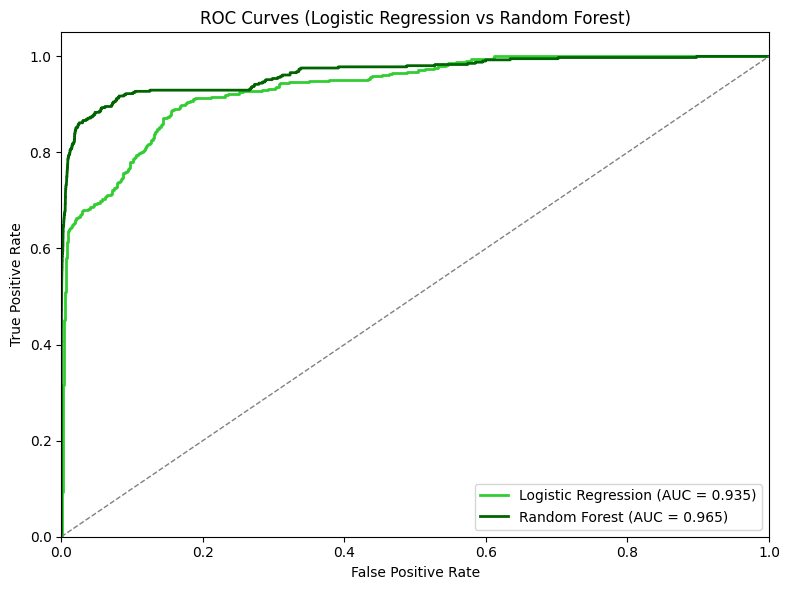

In [ ]:
# ROC curves
plt.figure(figsize=(8,6))
for name, model, shade in [
    ("Logistic Regression", best_lr, "limegreen"),
    ("Random Forest", best_rf, "darkgreen")
]:
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        continue
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, color=shade, lw=2, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0,1],[0,1], color='grey', lw=1, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Logistic Regression vs Random Forest)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("roc_comparison.png", dpi=200)
plt.show()

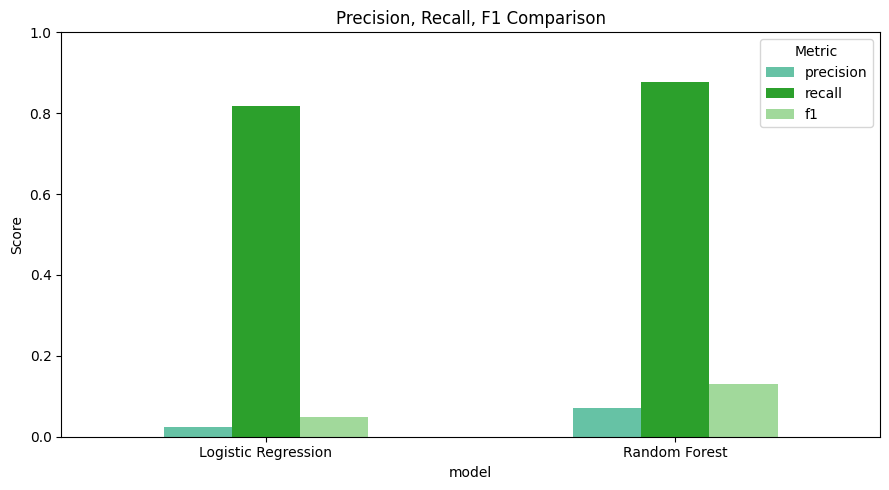

In [ ]:
# Metric bar plot
metrics_df = results.set_index("model")[["precision","recall","f1"]]
colors = ['#2ca02c','#66c2a5','#a1d99b']  # for the 3 metrics (will be cycled)
ax = metrics_df.plot(kind='bar', figsize=(9,5), color=['#66c2a5','#2ca02c','#a1d99b'])
plt.title("Precision, Recall, F1 Comparison")
plt.ylim(0,1)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.tight_layout()
plt.savefig("metric_barplot.png", dpi=200)
plt.show()


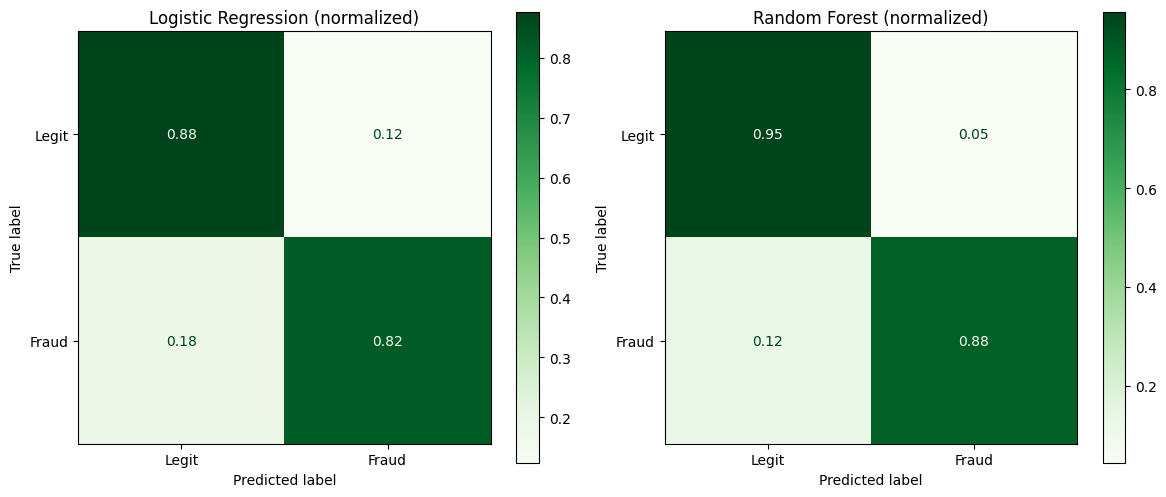

In [ ]:
# Confusion matrix
fig, axes = plt.subplots(1,2, figsize=(12,5))
for ax, (name, model) in zip(axes, [("Logistic Regression", best_lr), ("Random Forest", best_rf)]):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["Legit","Fraud"])
    disp.plot(ax=ax, cmap="Greens", values_format=".2f")
    ax.set_title(f"{name} (normalized)")
plt.tight_layout()
plt.savefig("confusion_matrices.png", dpi=200)
plt.show()

/tmp/ipython-input-4291933082.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_feats.values, y=top_feats.index, palette="Greens_r")


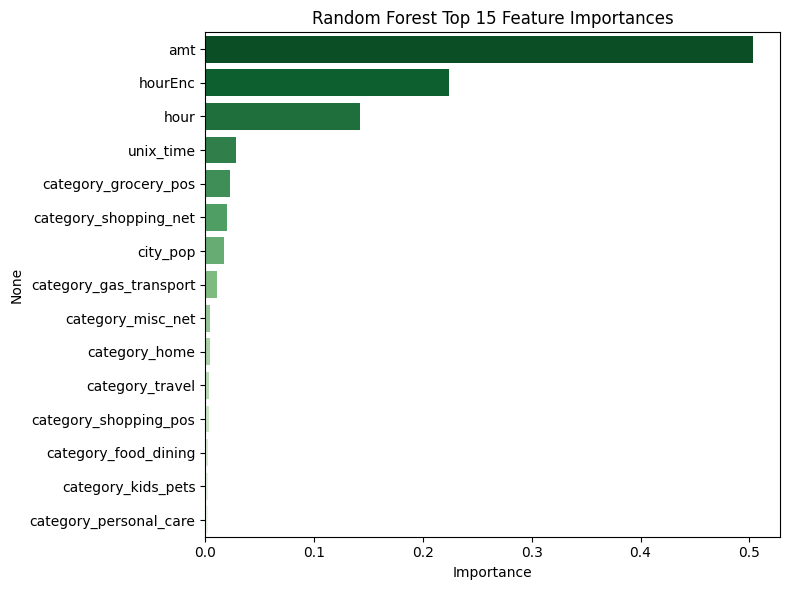

In [ ]:
# Feature importance (random forest)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
top_feats = feat_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=top_feats.values, y=top_feats.index, palette="Greens_r")
plt.title("Random Forest Top 15 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("rf_feature_importance.png", dpi=200)
plt.show()